This notebook demonstrates some of the basic functionality of the DUNE-TMS-SLAC repository (at least as it existed in late August 2025).
I'll also document here some of the basic To Dos and open bugs (none are particularly severe!)

This package was designed to be run on the full-spill MC developed by Alex Booth, though they likely will also work on earlier MC presuming that no changes were made to the spill structure or general file organization.
Each of the scripts in the python directory work sequentially. The chain runs: edep-sim -> TMS_DetectorEffects.py -> TMS_HitClustering.py -> TMS_ClusterToGraph.py -> TMS_ModelAndTrain.py (assuming you would like to do semantic label prediction). 

The TMS_DetectorEffects.py script in particular is designed to stand independent of the rest of the chain. This script handles all of the detector effects simulation (including hit-wise affects like optical attenuation and multi-hit effects like coincident hit merging), and produces output in the form of root files. You can see in detail how the root output is produced, including all of the functions producing the detector effects simulation, in the python script itself, I've tried my best to include documentation where code is unclear. Another resource to check out is the dune-tms TMS_Event.cxx script (or some similar name). My detector effects simulation was modeled after this, and in many places, simply pythonized directly from the C++ code to ensure consistency across reco packages. The first part of this notebook will review the output of the detector effects simulation run on a file. 

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import collections
import ROOT as root
import awkward as ak
import uproot
from array import array
import torch
from torch_geometric.data import Data, Dataset
import sys
import os

Welcome to JupyROOT 6.26/16


A brief note on imports and dependencies - this package is designed specifically to be run using the SLAC neutrino group singularity image (in particular I built it using "SINGULARITY_IMAGE_PATH=/sdf/group/neutrino/images/develop.sif"). This image should support all imported packages. If it yells at you, contact me or Kazu. 

The sdf location for the full-spill edep-sim files that serve as input to TMS_DetectorEffects.py is "/sdf/data/neutrino/summer25/tanaka/nd-production/run-spill-build/MicroProdN4p1_NDComplex_FHC.spill.full/EDEPSIM_SPILLS/". This contains a few subdirectories where the actual .root files are. I believe that there are 101 total files. If you are just interested in taking a look at some of the output and not running the script, you can find the most up-to-date version of the detsim output .root files here: "/sdf/data/neutrino/summer25/ktwall/full_spill_detsim/". As of writing not all the MC has been converted to this version of the detsim. Let's pick a file at random and check it out. I'll be using uproot to do my .root file navigation but one can also navigate via TBrowser(), or the PyROOT bindings. 

In [3]:
example_detsim_file = uproot.open("/sdf/data/neutrino/summer25/ktwall/full_spill_detsim/detsim_2557.root") #open the file with uproot. 

We can now pull the three trees and display their branches. A thing that is super important to note is that what maps to a branch entry differs across trees. For the Unmerged Tree, one entry corresponds to one unmerged hit, for the Merged Tree, one entry corresponds to one merged hit. There are definitionally fewer of these merged entries than unmerged entries (motivating them having different trees), and so the entry indices do NOT map to the same TMS hits across trees. One entry in the neutrino vertex tree maps to a single neutrino vertex. This tree saves ALL the neutrino vertices for a file, not just the ones producing TMS hits. This was done initially to get statistics on how many neutrino vertices are TMS fiducial, but could in principle be changed in the future. 

In [4]:
print(example_detsim_file.keys()) #show the constituent trees

['UnmergedTree;1', 'MergedTree;1', 'NeutrinoVertexTree;1']


In [5]:
#Pull our trees
UnmergedTree = example_detsim_file['UnmergedTree']
MergedTree = example_detsim_file['MergedTree']
NeutrinoTree = example_detsim_file['NeutrinoVertexTree']

In [6]:
#Unmerged Tree Branches
print(UnmergedTree.keys())

['neutrino_number', 'hit_number', 'spill_number', 'trackid', 'file_number', 'TrueHitX', 'TrueHitY', 'TrueHitZ', 'TrueHitT', 'TrueHitDx', 'TruePrimDep', 'DetSimHitX', 'DetSimHitY', 'DetSimHitZ', 'DetSimHitT', 'DetSimHitPE', 'DetSimHitBarNo', 'DetSimHitLayerNo', 'DetSimHitBarOrient']


In [7]:
#Merged Tree Branches
print(MergedTree.keys())

['MergedNeutrinoNumber', 'MergedHitNumber', 'MergedSpillNumber', 'MergedTrackid', 'MergedFileNumber', 'MergedTrueHitX', 'MergedTrueHitY', 'MergedTrueHitZ', 'MergedTrueHitT', 'MergedTrueHitDx', 'MergedTruePrimDep', 'MergedDetSimHitX', 'MergedDetSimHitY', 'MergedDetSimHitZ', 'MergedDetSimHitT', 'MergedDetSimHitPE', 'MergedDetSimHitBarNo', 'MergedDetSimHitLayerNo', 'MergedDetSimHitBarOrient', 'constituent_neutrino_numbers', 'constituent_hit_numbers', 'constituent_hit_trackids', 'constituent_hitTs', 'constituent_hitPEs']


In [8]:
#Neutrino Tree Branches
print(NeutrinoTree.keys())

['NeutrinoVtxX', 'NeutrinoVtxY', 'NeutrinoVtxZ', 'NeutrinoVtxT', 'NeutrinoNumber', 'FileNumber', 'NeutrinoSpill', 'VisibleHits', 'VisiblePEs']


Hopefully most of the branch names are intuitive, but you can check out the detector effects python file to see specifically how stuff gets filled. The easiest way to access information from within a branch is via the .array() or .arrays() method in uproot. 

In [28]:
neutrino_number_array_unmerged = UnmergedTree['neutrino_number'].arrays()
#grab the neutrino number of the first hit:
print(f"first hit neutrino number is: {neutrino_number_array_unmerged.neutrino_number[0]}")
#We can also grab information in bulk
unmerged_hit_data = UnmergedTree.arrays(
        ["neutrino_number", "hit_number", "trackid", "spill_number", "TrueHitX", "TrueHitY", "TrueHitZ", "TrueHitT", 
         "TrueHitDx", "TruePrimDep", "DetSimHitX", "DetSimHitY", "DetSimHitZ", "DetSimHitT", 
         "DetSimHitPE", "DetSimHitBarNo", "DetSimHitLayerNo", "DetSimHitBarOrient"],
        library="np"
    )
#Arrays of neutrino and spill numbers for all hits. Rather uniquely, we've found a file with only 12 spills! Most have 13. 
print(unmerged_hit_data["neutrino_number"], unmerged_hit_data["spill_number"])

first hit neutrino number is: 2
[   2    2    2 ... 5457 5457 5457] [ 0  0  0 ... 11 11 11]


Let's do something with this data and demonstrate our detector effects simulation. This next snippet will plot two event displays in x and z, one with the truth hits and PEs, and the other with the detector effect sim hits and PEs. 

In [48]:
# we want to be able to grab all the hits belonging to a specific neutrino number (ie, neutrino interaction)
chosen_interaction_nn = 5

#A quick way to do this is to take advantage of numpy array fancy indexing - a trick I use all the time in my scripts. First lets pull all the arrays we want. 

hit_nns = unmerged_hit_data["neutrino_number"]
true_xs = unmerged_hit_data["TrueHitX"]
true_zs = unmerged_hit_data["TrueHitZ"]
true_ts = unmerged_hit_data["TrueHitT"]
TruePrimDep = unmerged_hit_data["TruePrimDep"] * 50.0 #account for light yield to convert to PE

detsim_xs = unmerged_hit_data["DetSimHitX"]
detsim_zs = unmerged_hit_data["DetSimHitZ"]
detsim_ts = unmerged_hit_data["DetSimHitT"]
detsimDep = unmerged_hit_data["DetSimHitPE"]

#Now lets stack them column wise using np.column_stack

info_array = np.column_stack((hit_nns, true_xs, true_zs, true_ts, TruePrimDep, detsim_xs, detsim_zs, detsim_ts, detsimDep))

#Now we can use numpy fancy indexing to only pull the neutrino interaciton we are interested in:

selected_info_array = info_array[info_array[:,0] == chosen_interaction_nn]
print(np.unique(selected_info_array[:,0])) #nice, only have events with neutrino number matching our chosen one!

#Another fun thing to add would be a star at the location of the neutrino vertex. This is super easy, since our neutrino number maps directory to our entry index for the neutrino tree.
vtx_x = NeutrinoTree['NeutrinoVtxX'].array()[chosen_interaction_nn]
vtx_z = NeutrinoTree['NeutrinoVtxZ'].array()[chosen_interaction_nn]
#Now we can make our plots

[5.]


(-3650.0, 3650.0)

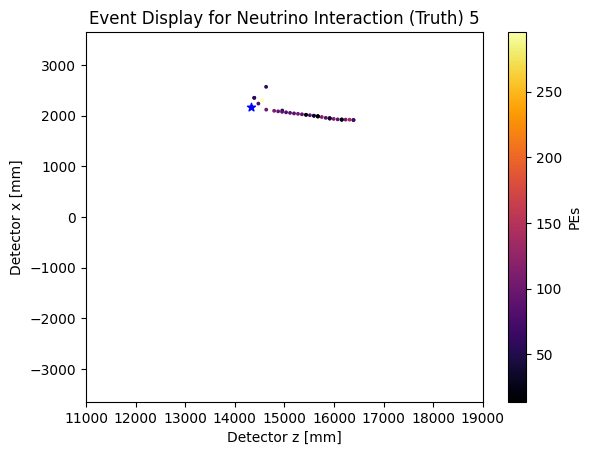

In [65]:
#Truth hit positions and PEs plot
plt.scatter(selected_info_array[:,2], selected_info_array[:,1], c = selected_info_array[:,4], cmap = 'inferno', s = 3)
plt.colorbar(label = 'PEs')
plt.scatter(vtx_z,vtx_x, marker = '*', c = 'blue')
plt.xlabel("Detector z [mm]")
plt.ylabel("Detector x [mm]")
plt.title(f"Event Display for Neutrino Interaction (Truth) {chosen_interaction_nn}")
plt.xlim((11000,19000))
plt.ylim((-3650,3650))

(-3650.0, 3650.0)

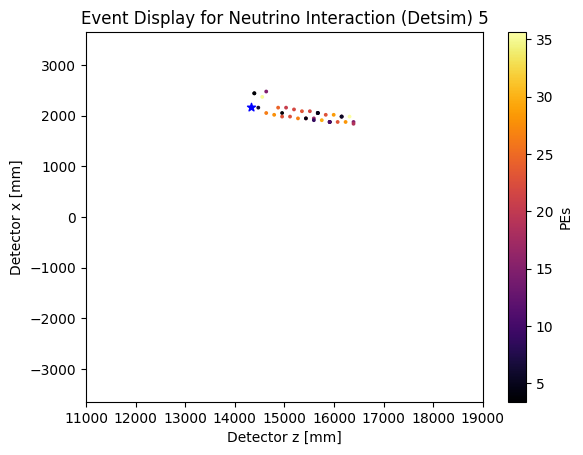

In [66]:
plt.scatter(selected_info_array[:,6], selected_info_array[:,5], c= selected_info_array[:,-1], cmap = 'inferno', s =3)
plt.colorbar(label = 'PEs')
plt.xlabel("Detector z [mm]")
plt.ylabel("Detector x [mm]")
plt.title(f"Event Display for Neutrino Interaction (Detsim) {chosen_interaction_nn}")
plt.scatter(vtx_z,vtx_x, marker = '*', c = 'blue')
plt.xlim((11000,19000))
plt.ylim((-3650,3650))

Fun stuff! THis appears to be a neutrino interaction starting in the TMS, and by comparing the two displays and the reported PEs we can get a sense of how the TMS geometry impacts the event. An important thing to note is that since we are pulling the unmerged hit detsim information and not the corresponding merged hits for this event, there are likely many points that are stacking on top of each other here where we see one scatterplot each. This is an odd quirk of edep-sim, but handled via hit merging. This leads to the PEs per hit being higher in the merged hits!